In [16]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
from urllib.parse import urlparse, parse_qs

In [89]:
result_file = Path("reactive_api_gateway_experiment_load_test_result.parquet.gzip")
if result_file.is_file():
    df = pd.read_parquet(result_file)
else:
    df = None

    def parse_request(url):
        parsed_url = urlparse(url)
        query = parse_qs(parsed_url.query)
        page_size = abs(int(query['offset'][0]))
        forward_direction = int(query['offset'][0]) > 0
        number_properties = len(query['properties'][0].split(','))
        return pd.Series({'page_size':page_size, 'forward_direction':forward_direction,'number_properties':number_properties })

    for test in ['orm','json','map']:    
        results = pd.read_csv(f"../../../target/logs/{test}_reactive_api_gateway_experiment_load_test_result.csv")
        results['test'] = test
        results = results.merge(results['URL'].apply(parse_request),left_index=True, right_index=True)
        columns = ['test','timeStamp', 'elapsed', 'responseCode','success','page_size', 'forward_direction', 'number_properties','Latency']
        if df is None:
            df = results[columns] 
        else:
            df = pd.concat([df,results[columns]]) 
            
    df.to_parquet(result_file,compression='gzip')
    
df.head()

test      timeStamp  elapsed  responseCode  success  page_size  \
index                                                                  
0      orm  1627321617557      335           200     True        578   
1      orm  1627321617893      387           200     True        590   
2      orm  1627321618281        9           200     True        494   
3      orm  1627321618291      235           200     True        661   
4      orm  1627321618527       31           200     True        611   

       forward_direction  number_properties  Latency  
index                                                 
0                   True                  1      333  
1                  False                  8      386  
2                   True                  7        9  
3                  False                  5      235  
4                  False                  2       31

<AxesSubplot:>

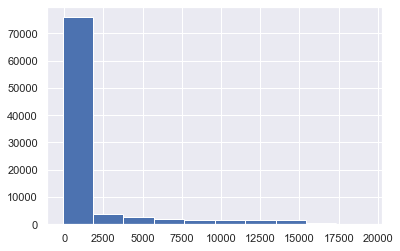

In [81]:
tests = list(df.test.unique())

pct_change = pd.DataFrame(columns=tests)

for test in tests:    
    pct_change[test] = df[df.test==test].Latency.pct_change(periods=1)*100

pd.set_option('use_inf_as_na', True)
pct_change.orm.dropna().hist()
# sns.lineplot(data=pct_change, x=pct_change.index, y="orm")

In [91]:
ds = df.groupby('test')['elapsed'].describe(include='all')
ds['range'] = ds['max']-ds['min']
ds['IQR'] = ds['75%']-ds['25%']
ds


count      mean        std  min  25%  50%   75%     max   range   IQR
test                                                                          
json  100000.0  34.90911  55.973398  0.0  1.0  4.0  52.0  3340.0  3340.0  51.0
map   100000.0  35.96867  69.678908  0.0  1.0  5.0  53.0  8249.0  8249.0  52.0
orm   100000.0  29.44848  47.297944  0.0  1.0  2.0  46.0   387.0   387.0  45.0

In [95]:
def is_outlier(s):
    lower_limit = s.mean() - (s.std() * 3)
    upper_limit = s.mean() + (s.std() * 3)
#     lower_limit = s.quantile(.01)
#     upper_limit = s.quantile(.99)
    return ~s.between(lower_limit, upper_limit)

df_no_outliers = df[~df.groupby('test')['elapsed'].apply(is_outlier)]
ds_no_outliers = df_no_outliers.groupby('test')['elapsed'].describe()
ds_no_outliers['range'] = ds_no_outliers['max']-ds['min']
ds_no_outliers['IQR'] = ds_no_outliers['75%']-ds['25%']
ds_no_outliers

count       mean        std  min  25%  50%   75%     max   range   IQR
test                                                                          
json  99945.0  34.904397  55.958732  0.0  1.0  4.0  52.0  3340.0  3340.0  51.0
map   99979.0  35.962502  69.658972  0.0  1.0  5.0  53.0  8249.0  8249.0  52.0
orm   99884.0  29.439370  47.284580  0.0  1.0  2.0  46.0   387.0   387.0  45.0

<AxesSubplot:>

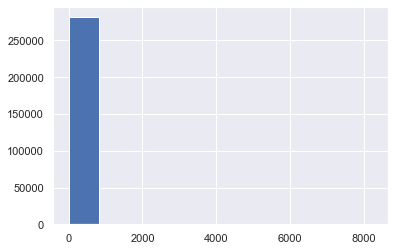

In [94]:
df_no_outliers.elapsed.hist()

<AxesSubplot:xlabel='index', ylabel='elapsed'>

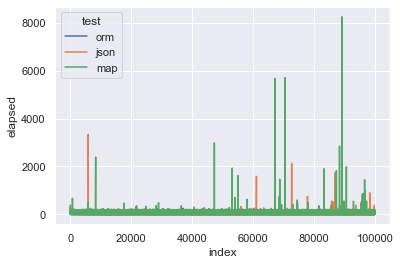

In [62]:
sns.lineplot(data=df_no_outliers, x=df_no_outliers.index, y="elapsed", hue="test")

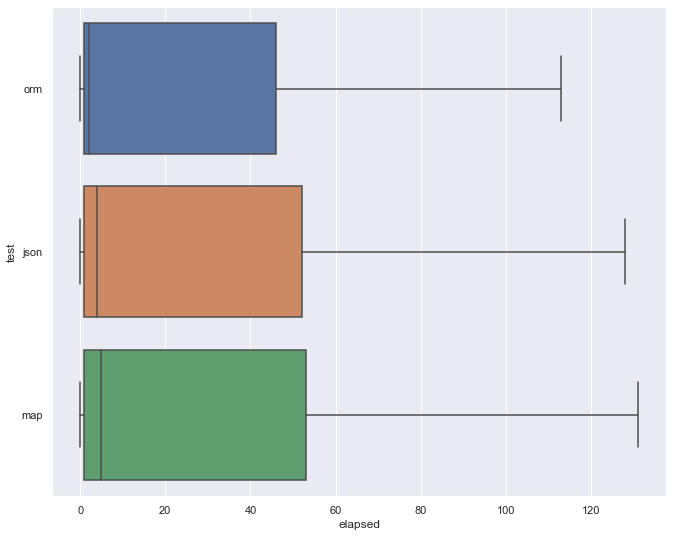

In [98]:
_ = plt.figure(figsize=(11, 9))
_ = sns.boxplot(y="test", x="elapsed", data=df_no_outliers, orient="h", showfliers = False)
_.figure.savefig("../../main/docs/reactive_api_gateway_experiment_load_test_result.png", bbox_inches='tight')